In [1]:
#IMPORT LIBRARIES
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#DEFINE MODELS
class ConvolutionalBlock(nn.Module):
    def __init__(self, kernel_name, in_channels, out_channels, kernel_size, stride, padding, activation_name=None):
        super(ConvolutionalBlock, self).__init__()
        kernel_layer = getattr(nn, kernel_name)
        self.covolutional_block = nn.Sequential(
            kernel_layer(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        )
        if activation_name is not None:
            activation = getattr(nn, activation_name) 
            self.covolutional_block.add_module('activation', activation())
                
    def forward(self, x):
        return self.covolutional_block(x)
##--------------------------------------------------------------------------------------------------------------   
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.residual = nn.Sequential(
            ConvolutionalBlock('Conv2d', in_channels, in_channels, 3, 1, 1, 'ReLU'),
            ConvolutionalBlock('Conv2d', in_channels, in_channels, 3, 1, 1, 'ReLU'))

    def forward(self, x):
        shortcut = x ##shortcut path
        out = self.residual(x) ##main path
        out += shortcut ##gather path
        return out
##--------------------------------------------------------------------------------------------------------------
class MultipleResiduals(nn.Module):
    def __init__(self, in_channels, num_repeat):
        super(MultipleResiduals, self).__init__()
        index = list(range(num_repeat))
        self.multiple_residuals = nn.Sequential()
        for i in range(num_repeat):
            self.multiple_residuals.add_module(f'{index[i]}th_multiple_residuals', ResidualBlock(in_channels))
    
    def forward(self, x):
        return self.multiple_residuals(x)    
##--------------------------------------------------------------------------------------------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ##generator look like autoencoder
        self.generator = nn.Sequential(
            ##encoder part
            ### calculate padding for Conv2d:
                ### (i - k + 2*p)/s + 1 = o round floor
                ### => p = (s(o-1) - i + k)/2 ##round up
                ### if s=1, o=i then p = (1(i-1) - i + k)/2 = (k-1)/2
            ###kernel_name, in_channels, out_channels, kernel_size, stride, padding, activation_name
            ConvolutionalBlock('Conv2d', 3, 64, 7, 1, 3, 'ReLU'), ### i
            ConvolutionalBlock('Conv2d', 64, 128, 3, 2, 1, 'ReLU'), ### i/2
            ConvolutionalBlock('Conv2d', 128, 256, 3, 2, 1, 'ReLU'), ### i/4
            
            ##transformer part
            MultipleResiduals(256, 6), ## i/4
            
            ##decoder part
            ### calculate padding for ConvTranspose2d:
                ###o = s(n-1) + k - 2p
                ###if s=2 then output = 2(n-1) + k - 2p = 2n - 2 + k -2p
            ###kernel_name, in_channels, out_channels, kernel_size, stride, padding, activation_name
            ConvolutionalBlock('ConvTranspose2d', 256, 128, 2, 2, 0, 'ReLU'), ### i/2
            ConvolutionalBlock('ConvTranspose2d', 128, 64, 2, 2, 0, 'ReLU'), ### i
            ConvolutionalBlock('Conv2d', 64, 3, 7, 1, 3, 'Tanh') ### i
        )

    def forward(self, x):
        return self.generator(x) ##output size(set_batch_size, 3, 256, 256)

In [3]:
#DEVICE AND TRANSFORM
##current device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
##transfrom image
custom_transform = transforms.Compose(
    [transforms.Resize((256,256)),
    transforms.ToTensor(),###to range [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])###to range [-1 1]

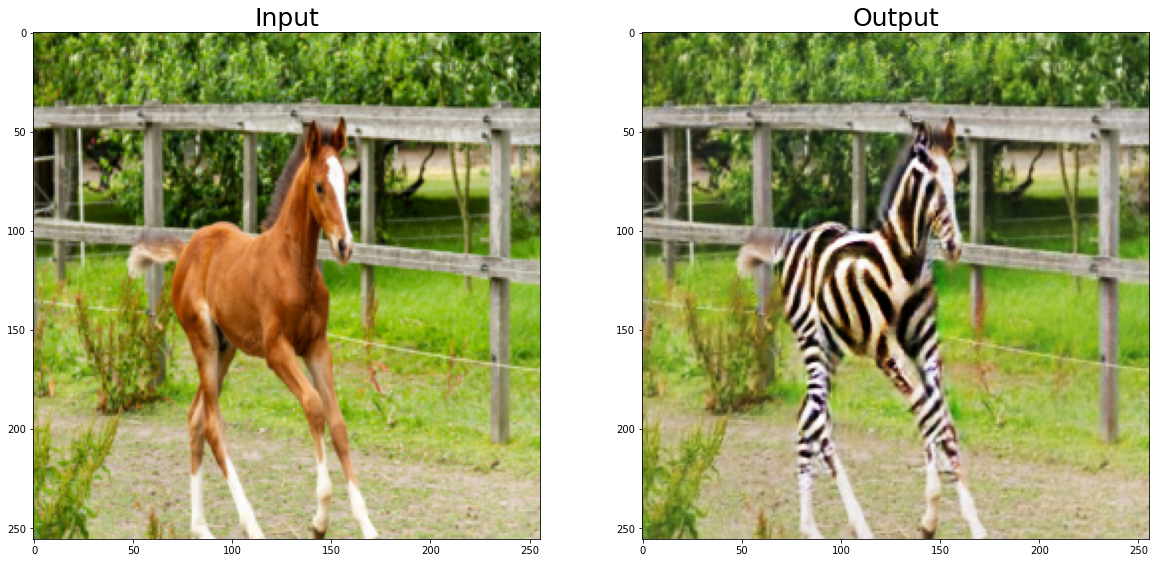

In [4]:
#CONVERT HORSE TO ZEBRA
##load model
G_AB = Generator()
G_AB.to(device)
G_AB.load_state_dict(torch.load('./static/inference/G_AB.pt', map_location=device))

##a horse image input
##Brown horse. https://unsplash.com/photos/QQvIGIrVhHo
input_image = Image.open('static/inference/horse_input.jpeg') 
input_image = custom_transform(input_image)
                                      
## generate a zebra image
with torch.no_grad():
    real_A = input_image.view(1, 3, 256, 256)
    real_A = real_A.to(device)
    fake_B = G_AB(real_A)
    input_image = input_image*0.5 + 0.5  ###unnormalize the tensor
    fake_B = fake_B*0.5 + 0.5 ###unnormalize the tensor
    ###covert tensor back to an image
    input_image = transforms.ToPILImage()(input_image)
    fake_B = fake_B.data.squeeze().cpu()
    output_image = transforms.ToPILImage()(fake_B)

##show images
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].set_title('Input', fontsize=25, fontweight=25)
ax[0].imshow(input_image)
ax[1].set_title('Output', fontsize=25, fontweight=25)
ax[1].imshow(output_image)
plt.show()

Note: Some outputs might not work as expected.

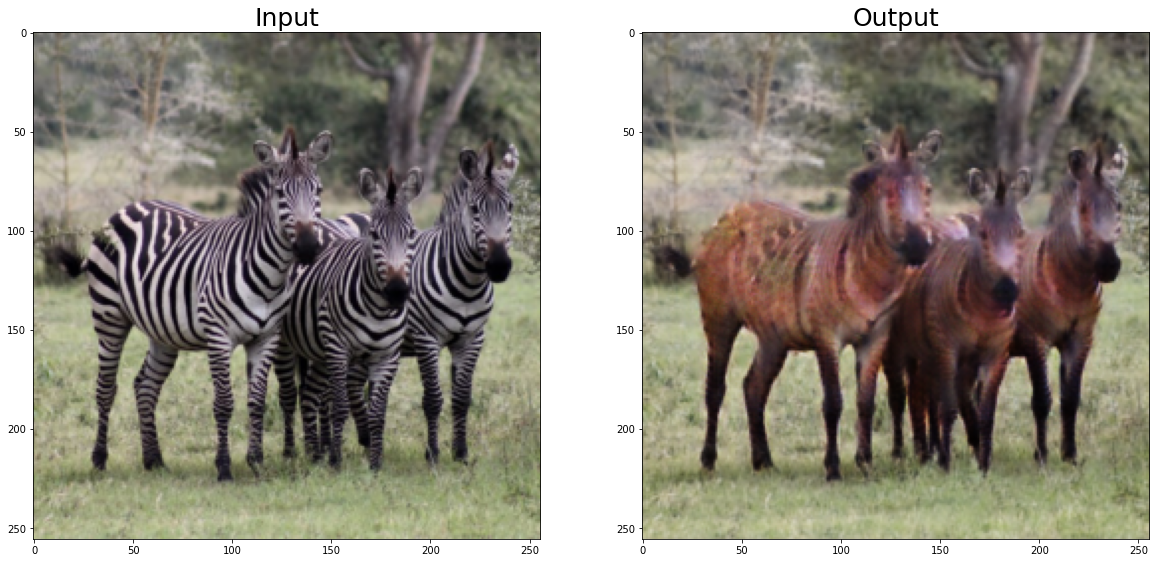

In [5]:
#CONVERT ZEBRA TO HORSE
##load model
G_BA = Generator()
G_BA.to(device)
G_BA.load_state_dict(torch.load('./static/inference/G_BA.pt', map_location=device))

##zebra image input
## Beautiful Zebras. https://unsplash.com/photos/MJi8Muk1k3Q
input_image = Image.open('static/inference/zebra_input.jpeg')
input_image = custom_transform(input_image)
                                      
## generate a horse image
with torch.no_grad():
    real_B = input_image.view(1, 3, 256, 256)
    real_B = real_B.to(device)
    fake_A = G_BA(real_B)
    input_image = input_image*0.5 + 0.5  ###unnormalize the tensor
    fake_A = fake_A*0.5 + 0.5 ###unnormalize the tensor
    ###covert tensor back to an image
    input_image = transforms.ToPILImage()(input_image)
    fake_A = fake_A.data.squeeze().cpu()
    output_image = transforms.ToPILImage()(fake_A)

##show images
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].set_title('Input', fontsize=25, fontweight=25)
ax[0].imshow(input_image)
ax[1].set_title('Output', fontsize=25, fontweight=25)
ax[1].imshow(output_image)
plt.show()

Note: Some outputs might not work as expected

In [6]:
#RELEASE GPU(s) MEMORY IF USING GPU(s)
del G_AB
del G_BA
torch.cuda.empty_cache()